In [16]:
from matplotlib import pyplot as plt# Dom laden: op elk tijdsstip t vraagt elke auto die wilt laden, max vermogen. Als boven cap: verschil met cap/#ladende auto's aftrekken van geladen vermogen.
import numpy as np
from profiles import users,time
print(users[0].get('passfail'))
import pandas as pd
userl = []
userl = users

[0.48304, 0.66667, 0.75893, 0.66667, 0.75893, 0.66667]


In [17]:
df = pd.read_csv('Productie en verbruik info Core.csv', delimiter=';')
# df.head()
pd.to_datetime(df.Datum.iloc[0] + ' ' + df.Tijd.iloc[0])
df.Datum = pd.to_datetime(df.Datum + ' ' + df.Tijd)
df.rename(columns={'Datum':'timestamp'}, inplace=True)
df.drop(['Tijd'], axis = 1, inplace = True)
df.head()

common = df.iloc[0:96,1]
pv = df.iloc[0:96,2]

cap = 12

In [18]:
def dumpProfile(userlist,timesteps,cap):
    newprofs = [[] for _ in range(len(userlist))]
    limit = []
    load = []

    for t in range(len(timesteps)):
        print(t)
        lim = cap - common[t] + pv[t]
        limit.append(lim)
        active = 0

        for u in userlist:
            count = u.get('count')
            demand = u.get('demandprof')[count]  #(soc0,soc1)
            profile = newprofs[userlist.index(u)]
            loadprof = u.get('loadprof')
            soc = u.get('soc')
            userd = u.get('user')
            soc0 = demand[0]*userd[1]
            soc1 = demand[1]*userd[1]


            if loadprof[t] == 0 or lim <0:  #niet beschikbaar of geen speling in verbruik
                profile.append(0)  #nul aan het laadprofiel toevoegen
                if t < len(loadprof)-1:
                    if loadprof[t+1] == 1:
                        soc[t] = soc0
                    else:
                        soc[t] = soc[t-1]
                else:
                    soc[t] = soc[t-1]

               
            elif loadprof[t] == 1 and soc[t] != soc1:  #als er geladen kan worden en de batterij nog niet volzit (soc einde maal capaciteit)

                        socn = soc[t-1] + userd[0]  #nieuwe soc, soc van vorig tijdstip + laadhoeveelheid dit tijdstip
                        active += 1
                        if socn >= soc1:
                            profile.append(userd[0]- (socn-userd[1]))
                            soc[t] = userd[1]  
                        else:
                            profile.append(userd[0])
                            soc[t] = socn 
                
            elif loadprof[t] == 1 and soc[t] == soc1:  #als er geladen kan worden maar de batterij zit al vol
                profile.append(0)
                soc[t] = userd[1]
            
            else:
                print("fout in verbruikverdeling")
            
            u.update({"soc":soc})

            if (loadprof[t] == 1 and t+1 < len(loadprof) and loadprof[t+1] == 0) or (loadprof[t] == 1 and t == len(loadprof)-1):

                    socE = u.get('soc')[t]
                    demandE = demand[1]*userd[1]
                    a = u.get('passfail')
                    a.append(round(socE/demandE,5))
                    u.update({"passfail":a})

                    if (count+1) < len(u.get('demandprof')):
                        new = count + 1
                    elif (count+1) >= len(u.get('demandprof')):
                        new = count
                    u.update({"count":new})
                    
        
        loads = [prof[t] for prof in newprofs ]
        ls = sum(loads)
        
        load.append(ls)
        if ls > abs(lim):
            diff = lim
            dep = diff/active
            for prof in newprofs:
                if prof[t] != 0:
                    a = dep
                    prof[t] = a if a>0 else 0
                    userlist[newprofs.index(prof)].get('soc')[t] = userlist[newprofs.index(prof)].get('soc')[t-1]+dep
            nload = [prof[t] for prof in newprofs ]
            load[t] = sum(nload)
    
    profiles = {"steps":timesteps,"cap":cap,"profiles":newprofs,"limit":limit,"load":load}
    
    # print("######################################")
    # print("vraag per timestep",load)
    # print("######################################")
    # for i in range (len(newprofs)):
    #     print("nieuwe laadprofielen user",i+1,newprofs[i])
    #     print("---------------------------------------------")
    
    # print("######################################")

    # for i in range(len(users)):
    #     print("state of charge user",i+1,users[i].get('soc'))
    #     print("---------------------------------------------")
    
    # print('"""""""""""""""""""""""""""""""""""""')

    # print("######################################")

    # for i in range(len(users)):
    #     print("passfail",i+1,users[i].get('passfail'))
    #     print("---------------------------------------------")
    
    return profiles


In [19]:
def plot(data):
    time = data.get('steps')
    plt.axhline(data.get("cap"),linestyle="dashed",label="limiet")
    for profile in data.get('profiles'):
        plt.step(time,profile,label=str("laadprofiel user"+str(data.get('profiles').index(profile) +1)),where="post")
    # plt.step(time,users[0].get('loadprof'),where="post")
    plt.step(time,data.get('limit'),linestyle="dashed",where="post",label="limiet")
    plt.step(time,data.get('load'),where="post",label="real load")
    plt.step(time,common,where="post",label="eigenverbruik")
    plt.step(time,pv,where="post",label="pv")

    plt.xticks(np.arange(0, 96, 1))
    # plt.yticks(np.arange(min(profiles.get("loads")), max(profiles.get("limit")), 5.0))
    plt.xlabel('time')
    plt.ylabel('kW')
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5,axis='y')
    plt.legend()
    plt.show()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


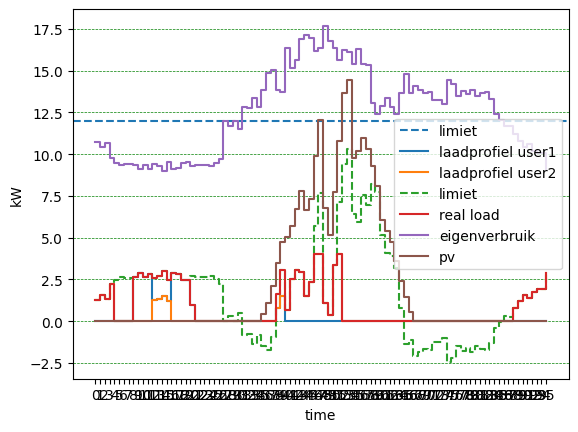

######################################
vraag per timestep [1.28499974, 1.5500000000000007, 1.3149999500000007, 2.235000052, 0, 0, 0, 0, 2.6224998960000008, 2.8874998440000006, 2.6224998960000008, 2.855000026000001, 2.587499844, 2.6849998960000008, 2.9874998440000002, 2.4574998180000005, 2.8599998959999997, 2.852499948, 2.4949999740000006, 2.4924998699999996, 0.9537509490000105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.6254998700000005, 3.04565995, 0.6911598399999992, 2.5425000299999994, 3.0678398199999997, 2.9484999000000007, 1.530499999999999, 2.3429998700000016, 4, 4, 1.1163399500000004, 0.37515974000000085, 3.3899998700000014, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.8099997400000003, 1.2099997400000007, 1.5474997399999992, 1.4124996900000006, 1.7774999499999993, 1.9424998700000007, 1.9424998700000007, 2.89249987]
######################################
nieuwe laadprofielen user 1 [0, 0, 0, 0, 0, 0, 0

In [20]:
profile = dumpProfile(userl,time,cap)
plot(profile)
print("######################################")
print("vraag per timestep",profile.get('load'))
print("######################################")
for i in range (len(profile.get('profiles'))):
        print("nieuwe laadprofielen user",i+1,profile.get('profiles')[i])
        print("---------------------------------------------")
for i in range(len(userl)):
        print("state of charge user",i+1,users[i].get('soc'))
        print("---------------------------------------------")
for i in range(len(userl)):
        print("passfail",i+1,users[i].get('passfail'))

del userl